In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
import jax.random as jr
from jax.tree_util import Partial

import hugegp as gp
# import hugegp_cuda as hgc
import jaxkd as jk

import matplotlib.pyplot as plt
import cmasher as cmr
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import time
from tqdm import tqdm

rng = jr.key(137)

In [3]:
import hugegp_cuda as gp_cuda

In [4]:
rng, k1 = jr.split(rng)
points = jr.normal(k1, shape=(5_000, 2))

graph = gp.build_graph(points, n0=100, k=10, cuda=True)
# graph = gp.build_lazy_graph(points, n0=100, k=16, factor=1.3)
gp.check_graph(graph)
covariance = gp.MaternCovariance(p=0, eps=1e-5)

In [5]:
cov_bins = gp.make_cov_bins(r_min=1e-5, r_max=10, n_bins=1000)

In [6]:
rng, k1 = jr.split(rng)
xi = jr.normal(k1, shape=(len(points),))

In [ ]:
values = gp.generate_jit(graph, (cov_bins, covariance), xi)
xi_back = gp.generate_inv_jit(graph, (cov_bins, covariance), values)
values_back = gp.generate_jit(graph, (cov_bins, covariance), xi_back)

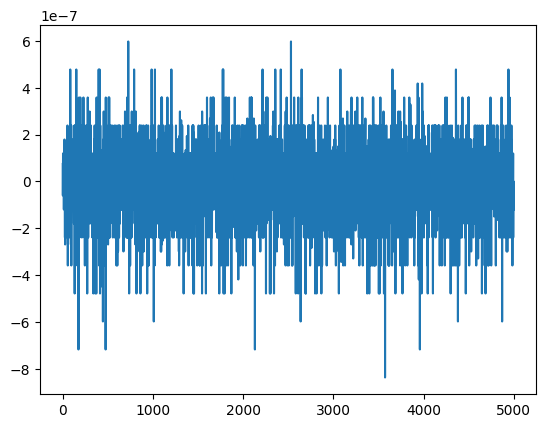

In [ ]:
plt.plot(values - values_back)

In [83]:
cuda_values = gp.generate(graph, (cov_bins, covariance), xi, cuda=True)
cuda_values

Array([-0.84527874, -0.33612138,  0.41439384, ...,  0.11314134,
        1.2413161 , -2.211014  ], dtype=float32)

(-0.0001, 0.0001)

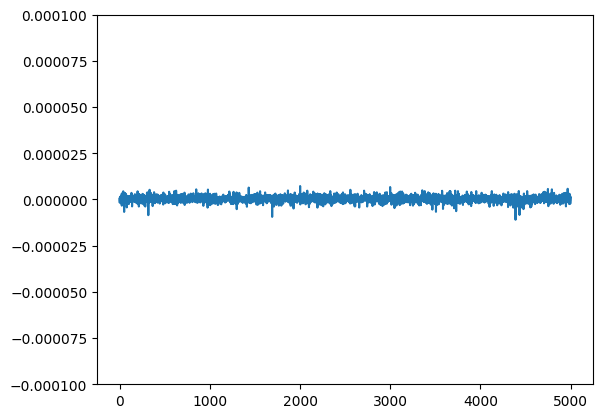

In [84]:
plt.plot(values - cuda_values)
plt.ylim(-1e-4, 1e-4)

In [53]:
rng, k1 = jr.split(rng)
xi = jr.normal(k1, shape=(len(points),))
values = gp.generate(graph, gp.MaternCovariance(p=0), xi)
values

Array([1.2794071 , 1.738562  , 0.7178262 , ..., 0.76837796, 1.2322326 ,
       0.5416563 ], dtype=float32)

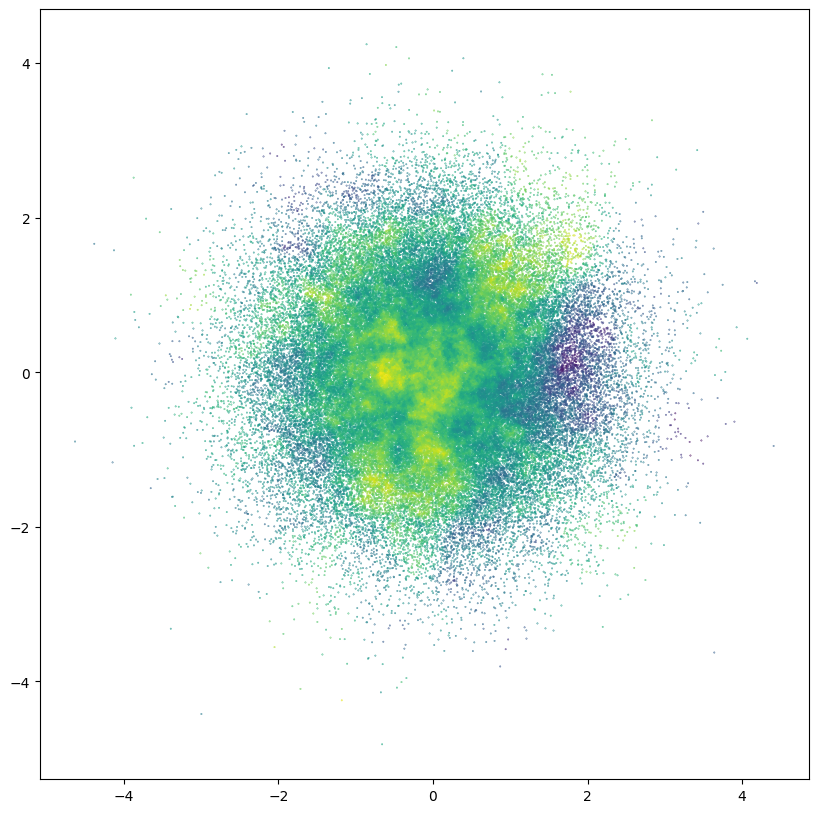

In [54]:
plt.figure(figsize=(10, 10))
plt.scatter(*points.T, c=values, s=.1)
plt.gca().set(aspect='equal')
plt.show()

# Inspect variance

In [3]:
rng, key = jr.split(rng)
points = jr.normal(key, shape=(5_000, 2))
graph = gp.build_graph(points, n0=100, k=16)
covariance = gp.MaternCovariance(p=0)

In [4]:
func = Partial(gp.generate, graph, covariance)
test_xi = jnp.zeros(len(points))
J = jax.jit(jax.jacfwd(func))(test_xi)
K = J @ J.T

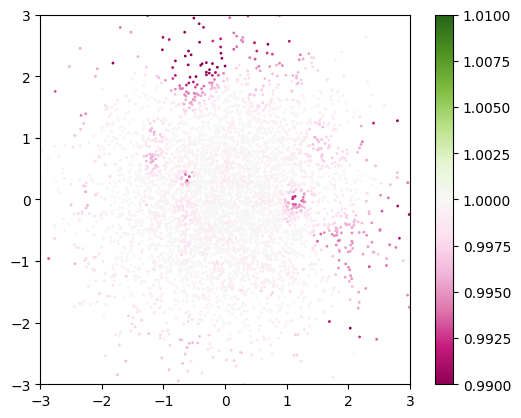

In [5]:
sigma = jnp.sqrt(jnp.diag(K))

plt.scatter(*points.T, c=sigma, cmap='PiYG', s=1, vmin=0.99, vmax=1.01)
plt.gca().set(aspect='equal', xlim=(-3,3), ylim=(-3,3))
plt.colorbar()
plt.show()

# Compare low number with exact

In [63]:
rng, key = jr.split(rng)
points = jr.normal(key, shape=(5_000, 2))
offsets = gp.make_offsets(len(points), 500, 1.3)
points, neighbors, indices = gp.build_jax_graph(points, offsets=offsets, k=20, cuda=True)
gp.check_graph(points, neighbors, offsets, indices)

In [64]:
rng, key = jr.split(rng)
xi = jr.normal(key, shape=(5_000,))

true_values = gp.generate_dense(points, gp.matern_cov, xi)
values = gp.generate(points, neighbors, offsets, gp.matern_cov, xi)

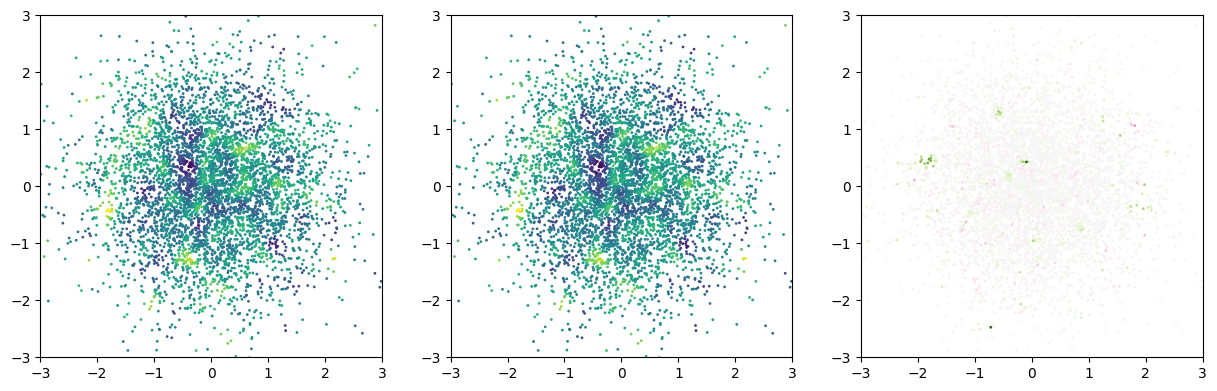

In [65]:
fig, axes = plt.subplots(figsize=(15,5), ncols=3)
axes[0].scatter(*points.T, c=true_values, s=1)
axes[1].scatter(*points.T, c=values, s=1)
axes[2].scatter(*points.T, c=true_values - values, s=1, cmap='PiYG', vmin=-1, vmax=1)
for ax in axes:
    ax.set(aspect='equal', xlim=(-3,3), ylim=(-3,3))
plt.show()